# Customer Orders Forecast

## Executive Summary

This project forecasts weekly warehouse order volumes across two demand streams:
- **Online** orders
- **Marketplace** orders

Using Holt–Winters Exponential Smoothing with damped trend and multiplicative seasonality,
the models capture strong half-year seasonality and structural demand shifts.

Forecasts are designed to support **warehouse staffing, capacity planning, and logistics operations**,
with explicit evaluation of forecast error and operational implications.

### Setup

BQ Query to collect shipment allocation data:  

```sql
SELECT
  LEFT(CAST(allocation_notification_process_date AS STRING), 10) AS order_date,
  CASE
    WHEN LEFT(order_number, 6) IN ('XX-EU-', 'XX-US-', 'XX-AP-') THEN 'online'
    ELSE 'mp'
  END AS channel,
  location_name,
  COUNT(DISTINCT order_number) AS order_count
FROM bi.shipment_allocation
WHERE DATE(allocation_notification_process_date) >= DATE('2024-01-01')
GROUP BY 1, 2, 3
ORDER BY 1, 2;

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pathlib

In [2]:
plt.style.use('ggplot')

In [3]:
path = str(pathlib.Path().absolute())

In [4]:
seasonality = 26
test_split = 0.2

In [5]:
def wape(y, yhat):
    return np.sum(np.abs(y - yhat)) / np.sum(np.abs(y))
def mape(y, yhat):
    return np.mean(np.abs((y - yhat) / y)) * 100

In [6]:
def to_index_with_base(s, base_value, base=100):
    s = s.astype(float).copy()
    return (s / base_value) * base

### Import Data

In [7]:
order_df = pd.read_csv(path[:-9] + '\\data\\shipment_allocation.csv', parse_dates=['order_date'])
order_df = order_df.loc[order_df['order_date'] >= '2024-01-01'].set_index('order_date')

In [8]:
print(order_df.info())
print(order_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2002 entries, 2024-01-01 to 2026-01-15
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   channel        2002 non-null   object
 1   location_name  2002 non-null   object
 2   order_count    2002 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 62.6+ KB
None
channel          0
location_name    0
order_count      0
dtype: int64


In [9]:
order_df['order_count'].resample('W-FRI').sum() # resample to weekly frequency, in the structure defined by the warehouse.
act_online = order_df.drop(columns=['location_name', 'channel']).loc[order_df['channel'] == 'online']['order_count'].resample('W-FRI').sum().asfreq('W-FRI', fill_value=1)
act_mp = order_df.drop(columns=['location_name', 'channel']).loc[order_df['channel'] == 'mp']['order_count'].resample('W-FRI').sum().asfreq('W-FRI', fill_value=1)

## Online Orders

In [10]:
online_orders = act_online[:-1] # exclude the last week which is incomplete

In [11]:
cut_off = int(round(len(online_orders)*-test_split, 0))
train_online_orders = online_orders[:cut_off]
test_online_orders = online_orders[cut_off:]

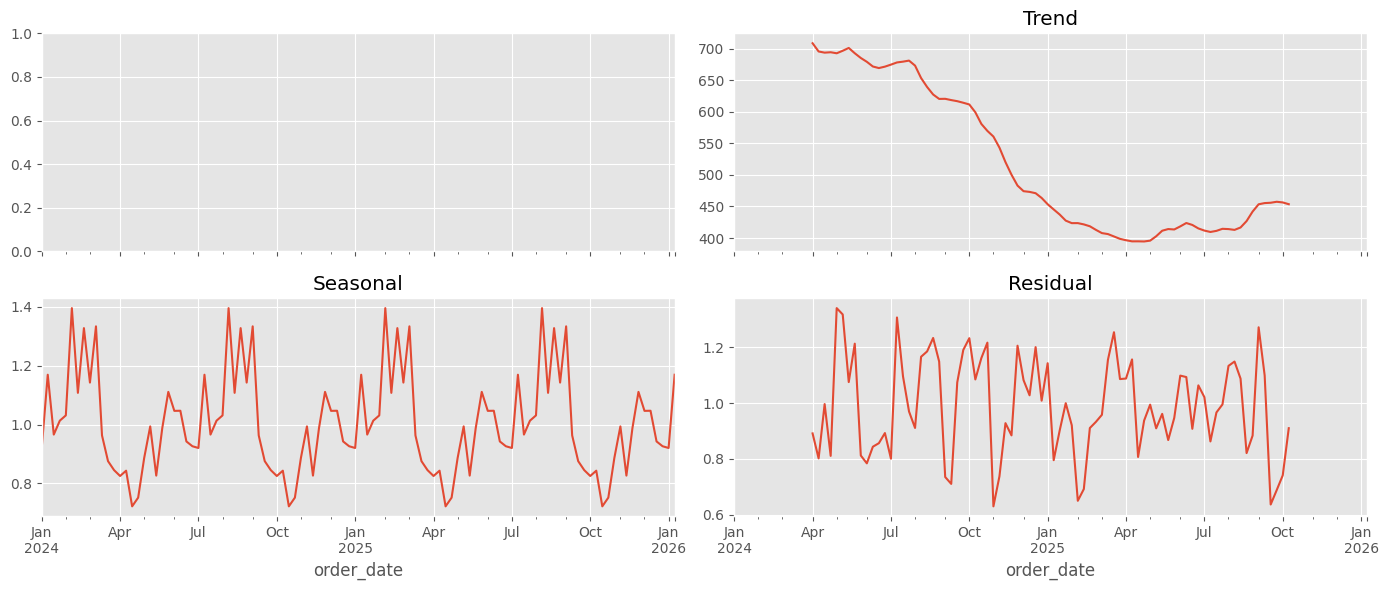

In [12]:
# Decomposition of the time series into its components (trend, seasonality, residuals) to understand the underlying patterns and characteristics of the data. 
# This helps in selecting appropriate forecasting models and understanding the behavior of the time series.

decomposition = seasonal_decompose(online_orders, model='multiplicative', period=26)

fig, axes = plt.subplots(2, 2, figsize=(14, 6), sharex=True)

# decomposition.observed.plot(ax=axes[0,0], title='Observed') # --> High volatility + strong noise --> trend modeling is required
decomposition.trend.plot(ax=axes[0,1], title='Trend') # --> systematic shift --> trend component present
decomposition.seasonal.plot(ax=axes[1,0], title='Seasonal') # --> half year seasonality predictable & high effect approx 30-40%
decomposition.resid.plot(ax=axes[1,1], title='Residual') # --> random noise present, no obvous pattern --> ok

plt.tight_layout()
plt.show()

In [13]:
# Additive vs Multiplicative model comparison
model_mul = ExponentialSmoothing(train_online_orders, seasonal='mul', trend='add', seasonal_periods=seasonality, damped_trend=True).fit()
pred_mul = model_mul.forecast(len(test_online_orders))

model_add = ExponentialSmoothing(train_online_orders, seasonal='add', trend='add', seasonal_periods=seasonality, damped_trend=True).fit()
pred_add = model_add.forecast(len(test_online_orders))

In [14]:
metrics = pd.DataFrame({
    "MAE": [
        mean_absolute_error(test_online_orders, pred_add),
        mean_absolute_error(test_online_orders, pred_mul)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(test_online_orders, pred_add)),
        np.sqrt(mean_squared_error(test_online_orders, pred_mul))
    ],
    "MAPE": [
        mape(test_online_orders, pred_add),
        mape(test_online_orders, pred_mul)
    ],
    "WAPE": [
        wape(test_online_orders, pred_add),
        wape(test_online_orders, pred_mul)
    ],
    "Bias": [
        np.mean(pred_add - test_online_orders),
        np.mean(pred_mul - test_online_orders)
    ]
}, index=["Additive", "Multiplicative"])

metrics

,MAE,RMSE,MAPE,WAPE,Bias
Additive,156.169388,195.220988,32.117293,0.352678,-72.882663
Multiplicative,138.135599,179.677056,28.227080,0.311953,-53.384935


In [15]:
base_val = online_orders.replace(0, np.nan).dropna().iloc[0]

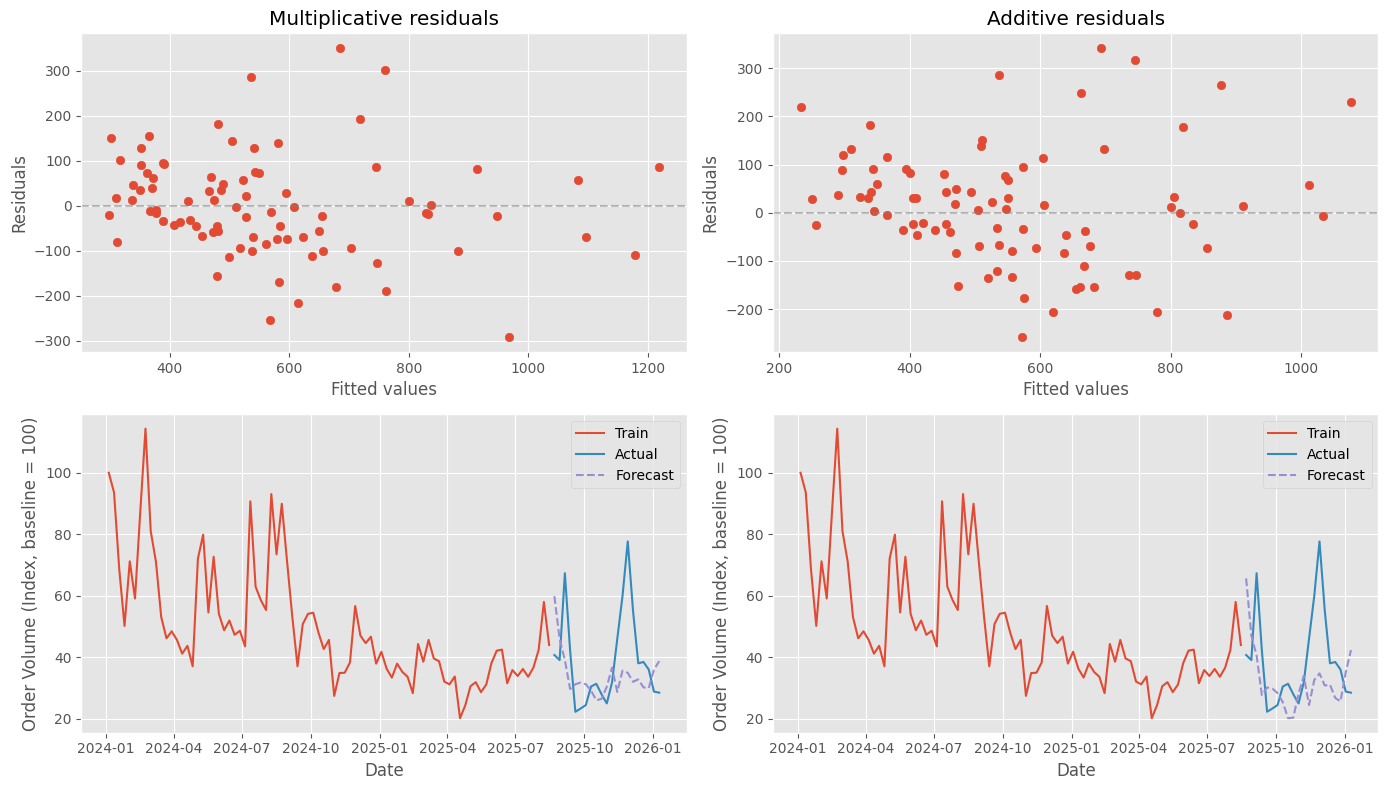

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].scatter(model_mul.fittedvalues, model_mul.resid)
axes[0, 0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].set_title("Multiplicative residuals")
axes[0, 0].set_xlabel("Fitted values")
axes[0, 0].set_ylabel("Residuals")

axes[0, 1].scatter(model_add.fittedvalues, model_add.resid)
axes[0, 1].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].set_title("Additive residuals")
axes[0, 1].set_xlabel("Fitted values")
axes[0, 1].set_ylabel("Residuals")

train_online_idx = to_index_with_base(train_online_orders, base_val)
test_online_idx = to_index_with_base(test_online_orders, base_val)
pred_mul_idx = to_index_with_base(pred_mul, base_val)
pred_add_idx = to_index_with_base(pred_add, base_val)

axes[1, 0].plot(train_online_idx.index, train_online_idx, label='Train')
axes[1, 0].plot(test_online_idx.index, test_online_idx, label='Actual')
axes[1, 0].plot(pred_mul_idx.index, pred_mul_idx, label='Forecast', linestyle='--')
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Order Volume (Index, baseline = 100)")
axes[1, 0].legend()

axes[1, 1].plot(train_online_idx.index, train_online_idx, label='Train')
axes[1, 1].plot(test_online_idx.index, test_online_idx, label='Actual')
axes[1, 1].plot(pred_add_idx.index, pred_add_idx, label='Forecast', linestyle='--')
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("Order Volume (Index, baseline = 100)")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

**Selected model: Multiplicative with damped trend**

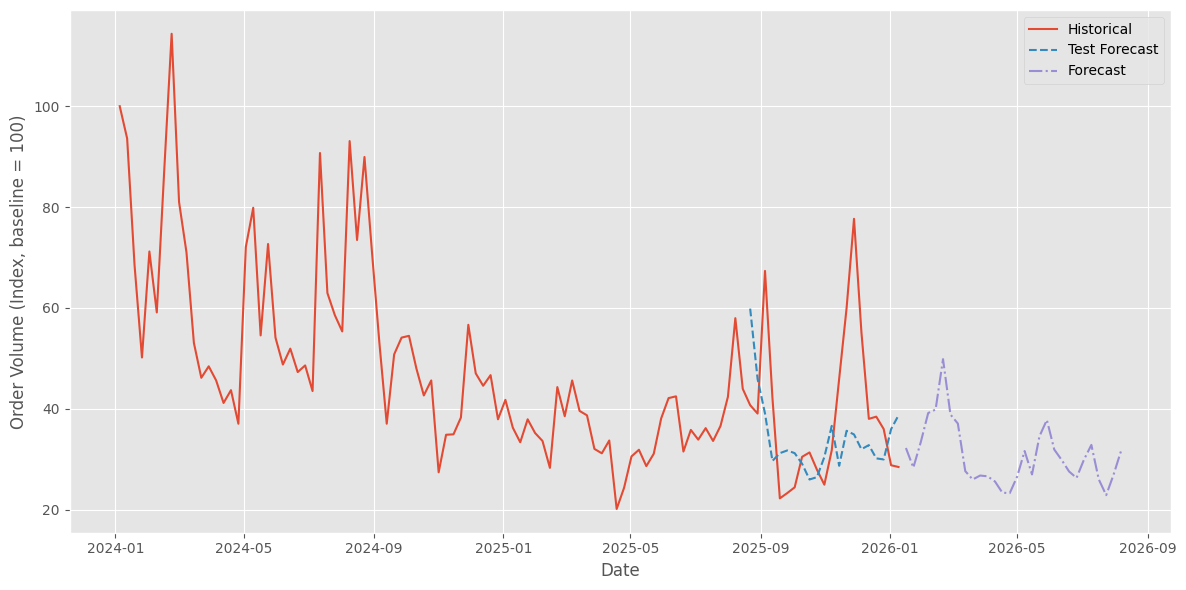

In [17]:
final_model = ExponentialSmoothing(online_orders, seasonal='mul', trend='add', seasonal_periods=seasonality, damped_trend=True).fit()
future_forecast = final_model.forecast(30)

online_orders_idx = to_index_with_base(online_orders, base_val)
pred_mul_idx = to_index_with_base(pred_mul, base_val)
future_forecast_idx = to_index_with_base(future_forecast, base_val)

plt.figure(figsize=(12, 6))
plt.plot(online_orders_idx.index, online_orders_idx, label='Historical')
plt.plot(pred_mul_idx.index, pred_mul_idx, label='Test Forecast', linestyle='--')
plt.plot(future_forecast_idx.index, future_forecast_idx, label='Forecast', linestyle='dashdot')
plt.xlabel("Date")
plt.ylabel("Order Volume (Index, baseline = 100)")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
online_export = pd.concat([online_orders, future_forecast]) 
online_export = online_export.rename('qty_com').reset_index().rename(columns={'index': 'Week_Ending'})
online_export['qty_com'] = online_export['qty_com'].round(-1).astype(int)
online_export.to_csv(f'{path[:-9]}\\data\\order_online_{str(dt.date.today()).replace("-", "")}.csv', index=False)

## Marketplace Orders

In [19]:
marketplace_orders = act_mp[:-1] # last week excluded due to incompleteness

In [20]:
cut_off = int(round(len(marketplace_orders)*-test_split, 0))
train_marketplace_orders = marketplace_orders[:cut_off]
test_marketplace_orders = marketplace_orders[cut_off:]

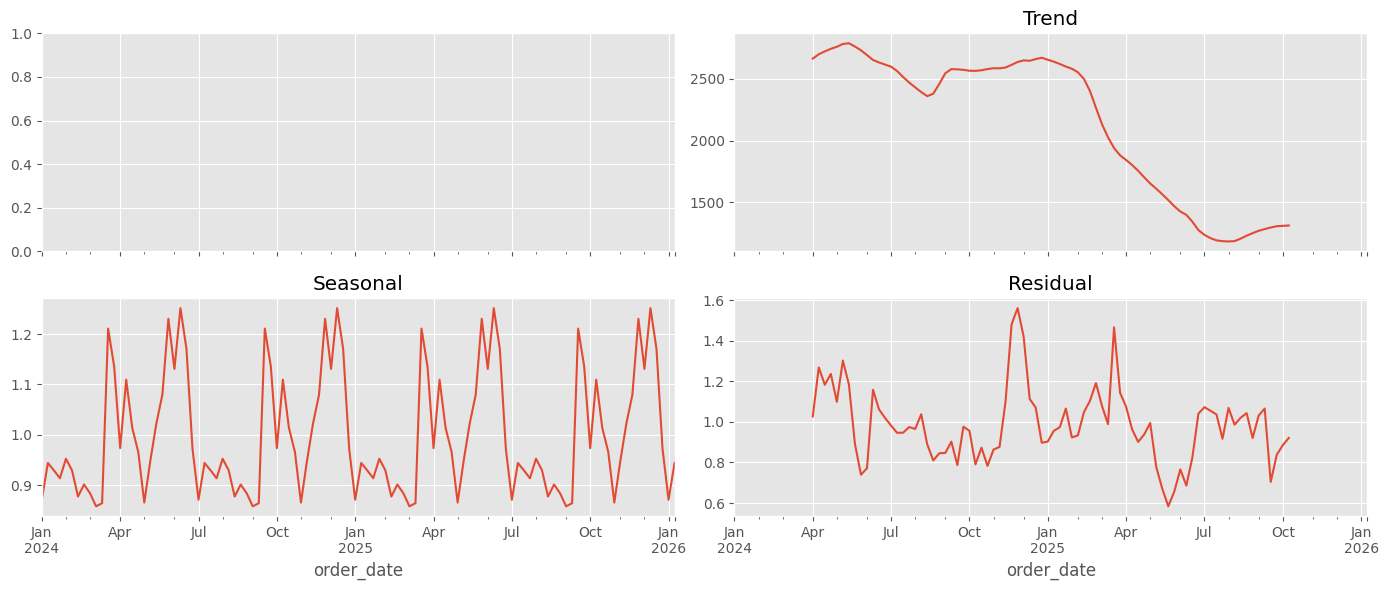

In [21]:
# Decomposition

decomposition = seasonal_decompose(marketplace_orders, model='multiplicative', period=26)

fig, axes = plt.subplots(2, 2, figsize=(14, 6), sharex=True)

# decomposition.observed.plot(ax=axes[0,0], title='Observed') # --> High volatility + string noise --> trend modeling is required
decomposition.trend.plot(ax=axes[0,1], title='Trend') # --> systematic shift --> trend component present
decomposition.seasonal.plot(ax=axes[1,0], title='Seasonal') # --> half year seasonality predictable & high effect approx 30-40%
decomposition.resid.plot(ax=axes[1,1], title='Residual') # --> random noise present, no obvous pattern --> ok

plt.tight_layout()
plt.show()

In [22]:
# Additive vs Miltiplicative model comparison
model_mul = ExponentialSmoothing(train_marketplace_orders, seasonal='mul', trend='add', seasonal_periods=seasonality, damped_trend=True).fit()
pred_mul = model_mul.forecast(len(test_marketplace_orders))

model_add = ExponentialSmoothing(train_marketplace_orders, seasonal='add', trend='add', seasonal_periods=seasonality, damped_trend=True).fit()
pred_add = model_add.forecast(len(test_marketplace_orders))

In [23]:
metrics = pd.DataFrame({
    "MAE": [
        mean_absolute_error(test_marketplace_orders, pred_add),
        mean_absolute_error(test_marketplace_orders, pred_mul)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(test_marketplace_orders, pred_add)),
        np.sqrt(mean_squared_error(test_marketplace_orders, pred_mul))
    ],
    "MAPE": [
        mape(test_marketplace_orders, pred_add),
        mape(test_marketplace_orders, pred_mul)
    ],
    "WAPE": [
        wape(test_marketplace_orders, pred_add),
        wape(test_marketplace_orders, pred_mul)
    ],
    "Bias": [
        np.mean(pred_add - test_marketplace_orders),
        np.mean(pred_mul - test_marketplace_orders)
    ]
}, index=["Additive", "Multiplicative"])

metrics

,MAE,RMSE,MAPE,WAPE,Bias
Additive,316.459892,410.252951,23.136827,0.231734,191.773260
Multiplicative,205.406764,249.180716,15.002653,0.150413,-88.717493


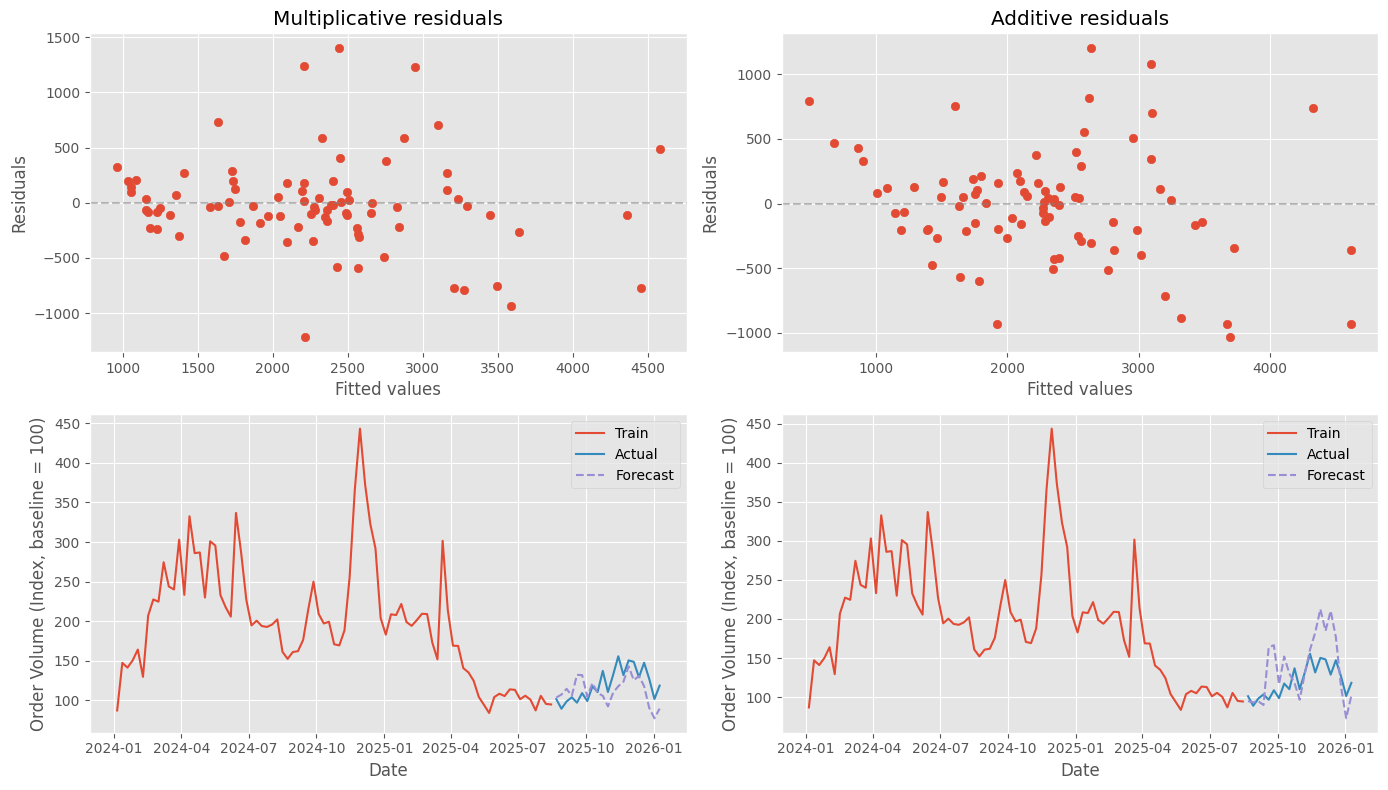

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].scatter(model_mul.fittedvalues, model_mul.resid)
axes[0, 0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].set_title("Multiplicative residuals")
axes[0, 0].set_xlabel("Fitted values")
axes[0, 0].set_ylabel("Residuals")

axes[0, 1].scatter(model_add.fittedvalues, model_add.resid)
axes[0, 1].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].set_title("Additive residuals")
axes[0, 1].set_xlabel("Fitted values")
axes[0, 1].set_ylabel("Residuals")

train_marketplace_idx = to_index_with_base(train_marketplace_orders, base_val)
test_marketplace_idx = to_index_with_base(test_marketplace_orders, base_val)
pred_mul_idx = to_index_with_base(pred_mul, base_val)
pred_add_idx = to_index_with_base(pred_add, base_val)

axes[1, 0].plot(train_marketplace_idx.index, train_marketplace_idx, label='Train')
axes[1, 0].plot(test_marketplace_idx.index, test_marketplace_idx, label='Actual')
axes[1, 0].plot(pred_mul_idx.index, pred_mul_idx, label='Forecast', linestyle='--')
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Order Volume (Index, baseline = 100)")
axes[1, 0].legend()

axes[1, 1].plot(train_marketplace_idx.index, train_marketplace_idx, label='Train')
axes[1, 1].plot(test_marketplace_idx.index, test_marketplace_idx, label='Actual')
axes[1, 1].plot(pred_add_idx.index, pred_add_idx, label='Forecast', linestyle='--')
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("Order Volume (Index, baseline = 100)")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

**Selected model: Multiplicative with damped trend**

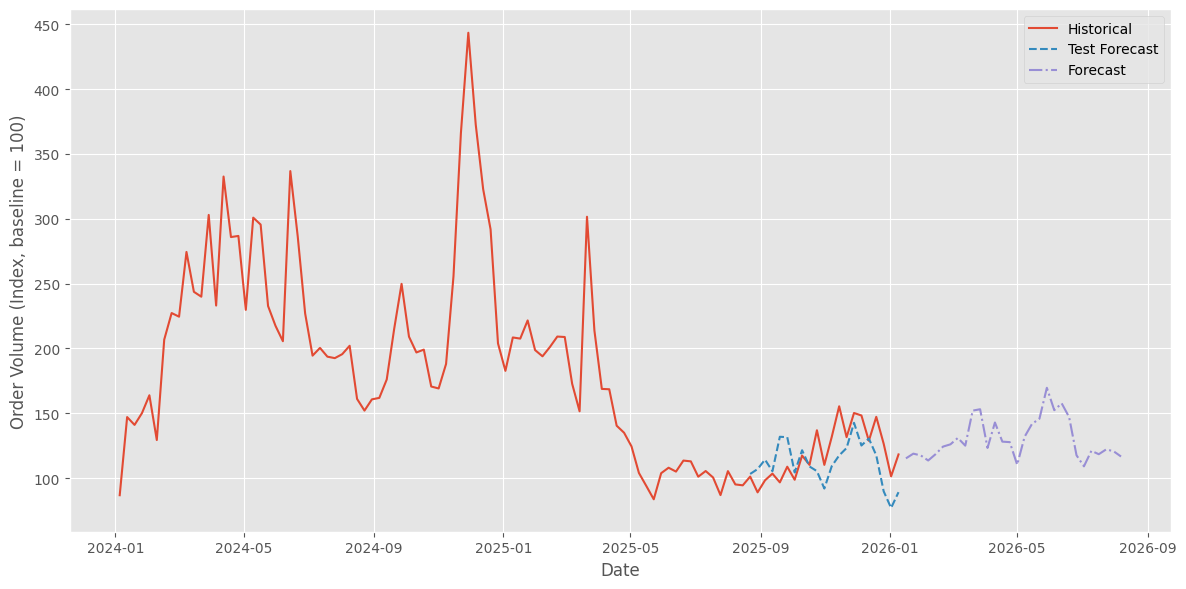

In [25]:
final_model = ExponentialSmoothing(marketplace_orders, seasonal='mul', trend='add', seasonal_periods=seasonality, damped_trend=True).fit()
future_forecast = final_model.forecast(30)

marketplace_orders_idx = to_index_with_base(marketplace_orders, base_val)
pred_mul_idx = to_index_with_base(pred_mul, base_val)
future_forecast_idx = to_index_with_base(future_forecast, base_val)

plt.figure(figsize=(12, 6))
plt.plot(marketplace_orders_idx.index, marketplace_orders_idx, label='Historical')
plt.plot(pred_mul_idx.index, pred_mul_idx, label='Test Forecast', linestyle='--')
plt.plot(future_forecast_idx.index, future_forecast_idx, label='Forecast', linestyle='dashdot')
plt.xlabel("Date")
plt.ylabel("Order Volume (Index, baseline = 100)")
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
mp_export = pd.concat([marketplace_orders, future_forecast]) 
mp_export = mp_export.rename('qty_mp').reset_index().rename(columns={'index': 'Week_Ending'})
mp_export['qty_mp'] = mp_export['qty_mp'].round(-1).astype(int)
mp_export.to_csv(f'{path[:-9]}\\data\\order_mp_{str(dt.date.today()).replace("-", "")}.csv', index=False)

## Merge & Export File

In [27]:
df = pd.merge(online_export, mp_export, how='outer', on='Week_Ending')
df.to_excel(f'{path[:-9]}\\data\\{str(dt.date.today())}_orders_forecast.xlsx')

### Operational Interpretation
- Peak periods require additional contingency capacity
- Forecasts should be refreshed weekly during high season